# Imports and constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from NearFieldOptics import TipModels as T
from NearFieldOptics.Materials import *
from NearFieldOptics.Materials.material_types import *
from NearFieldOptics.Materials.TransferMatrixMedia import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from CSV_Handler import CSV_Handler
from scipy.interpolate import interp1d
import warnings
warnings.simplefilter("ignore")

ASPECT_RATIO = 4/3
FIGURE_WIDTH  = 3.375
FIGURE_HEIGHT = FIGURE_WIDTH/ASPECT_RATIO
HALF_COL_FIGSIZE     = (0.5*FIGURE_WIDTH, 0.5*FIGURE_HEIGHT)
ONE_COL_FIGSIZE      = (1.0*FIGURE_WIDTH, 1.0*FIGURE_HEIGHT)
ONE_HALF_COL_FIGSIZE = (1.5*FIGURE_WIDTH, 1.5*FIGURE_HEIGHT)
TWO_COL_FIGSIZE      = (2.0*FIGURE_WIDTH, 2.0*FIGURE_HEIGHT)
DPI = 300

# Data collection

In [2]:
BSCCO_data, BSCCO_interp_fxn = {},{}
DyBCO_data, DyBCO_interp_fxn = {},{}
NAME_DICT = {
    'e1ab': '\epsilon_{1ab}',
    'e2ab': '\epsilon_{2ab}',
    'e1c': '\epsilon_{1c}',
    'e2c': '\epsilon_{2c}'
}
Y_LABEL_DICT = {
    'e1ab': '\epsilon',
    'e2ab': '\epsilon',
    'e1c': '\epsilon',
    'e2c': '\epsilon'
}

csvh = CSV_Handler('Bi2212_gr_transport_data.csv', '300K', BSCCO_data, datadir="./data/BSCCO", opt_consts = ['R','V'],include_k=False)

csvh = CSV_Handler('Bi2212_k_Tu_e1ab_e2ab_Tajima_e1c_e2c_10K_JPR_fixed.csv', '10K', BSCCO_data,\
                   datadir="./collated_data/", opt_consts = ['e1ab','e2ab','e1c','e2c'])
csvh = CSV_Handler('Bi2212_k_Tu_e1ab_e2ab_Kovaleva_e1c_e2c_150K.csv', '150K', BSCCO_data,\
                   datadir="./collated_data/", opt_consts = ['e1ab','e2ab','e1c','e2c'])
csvh = CSV_Handler('Bi2212_k_Tu_e1ab_e2ab_Tajima_e1c_e2c_300K.csv', '300K', BSCCO_data,\
                   datadir="./collated_data/", opt_consts = ['e1ab','e2ab','e1c','e2c'])

csvh = CSV_Handler('DyBCO_e1_e2_model_10K.csv', '10K', DyBCO_data, datadir="./data/DyBCO", opt_consts = ['e1ab','e2ab'])
csvh = CSV_Handler('DyBCO_e1_e2_model_100K.csv', '100K', DyBCO_data, datadir="./data/DyBCO", opt_consts = ['e1ab','e2ab'])

# Function definitions

In [3]:
def show_data_avail(data,name):
    print("Available data for {}:".format(name))
    for temp in data.keys():
        print("\t"+temp+':')
        for oc in data[temp].keys():
            if oc[:2]!="k_":
                print("\t\t{}".format(oc))

def calculate_loss(data):
    for temp in data.keys():
        directions = []
        for oc in data[temp].keys():
            #if "k_" not in oc and "loss_" not in oc:
            if "k_" not in oc and "loss_" not in oc and oc != "R" and oc !="V":
                d = oc[2:]
                if d not in directions:
                    directions.append(d)
        for d in directions:
            e1 = np.array(data[temp]['e1'+d])
            e2 = np.array(data[temp]['e2'+d])
            eps = e1+1j*e2
            loss = np.imag(-1/eps)
            data[temp]['loss_'+d] = loss
            
def plot_opt_consts(data, opt_consts=['e1ab'], scale_factors=None,
                    temps=None, axis=None, show_hyperbolic=False,
                    logx=False, logy=False, save=False, fname=None):
    fig = plt.figure(figsize=(3.375,0.5*3.375/ASPECT_RATIO), dpi=DPI)
    ocs = []
    if scale_factors is None:
        scale_factors = [1]*len(opt_consts)
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('symlog', linthresh=1e-1)
    if temps is None:
        temps = data.keys()
    for temp in temps:
        for scale,oc in zip(scale_factors,opt_consts):
            if scale!=1:
                lab = '$'+NAME_DICT[oc]+'$('+temp+') [x$10^{-5}]$'
                #lab = '${}*{}$('.format(scale,NAME_DICT[oc])+temp+')'
            else:
                lab = '${}$('.format(NAME_DICT[oc])+temp+')'
            x_data, y_data = data[temp]['k_'+oc], data[temp][oc]
            f_interp = interp1d(x_data, y_data, kind = 'cubic')
            x_interp = np.linspace(np.min(x_data), np.max(x_data), 10*len(x_data))
            ocs.append(f_interp(x_interp))
            plt.plot(x_interp, scale*f_interp(x_interp), label=lab)

    plt.legend(prop={'size':6})
    plt.xlabel("k (cm$^{-1}$)")
    plt.ylabel("${}$".format(Y_LABEL_DICT[opt_consts[0]]))
    if show_hyperbolic:
        plt.fill_between(x_interp,-1e9,1e5, color="#9BFF8B", where=ocs[0]*ocs[1]<0)
        plt.axhline(y=0,color="black", linestyle="--")
    if axis is not None:
        plt.axis(axis)
    if fname is None:
        fname = "{}_{}.png".format('_'.join(opt_consts), '_'.join(temps))
    if save:
        plt.savefig(fname, dpi=DPI, bbox_inches="tight")

def plot_loss(data, directions=['ab'], temps=None, axis=None, save=False, logx=False, logy=False, interp=False):
    fig = plt.figure()
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('symlog')
    if temps is None:
        temps = data.keys()
    for temp in temps:
        for direction in directions:
            lab = '$-\Im(\epsilon_{'+direction+'}^{-1})$('+temp+')'
            x_data = data[temp]['k_e1'+direction]
            y_data = data[temp]["loss_"+direction]
            f_interp = interp1d(x_data, y_data, kind="cubic")
            x_interp = np.linspace(np.min(x_data), np.max(x_data), 2*len(x_data))
            if interp:
                plt.plot(x_interp, f_interp(x_interp), label=lab)
            else:
                plt.plot(x_data, y_data, label=lab)

    plt.legend()
    plt.xlabel("k (cm$^{-1}$)")
    plt.ylabel("$-\Im(\epsilon^{-1})$")
    if axis is not None:
        plt.axis(axis)
    fname = "{}_{}.png".format('loss_'+'_'.join(directions), '_'.join(temps))
    if save:
        plt.savefig(fname, dpi=300)

show_data_avail(BSCCO_data,"Bi-2212")
calculate_loss(BSCCO_data)
calculate_loss(DyBCO_data)

Available data for Bi-2212:
	300K:
		R
		V
		e1ab
		e2ab
		e1c
		e2c
	10K:
		e1ab
		e2ab
		e1c
		e2c
	150K:
		e1ab
		e2ab
		e1c
		e2c


# Paper Figures

## Figure 1

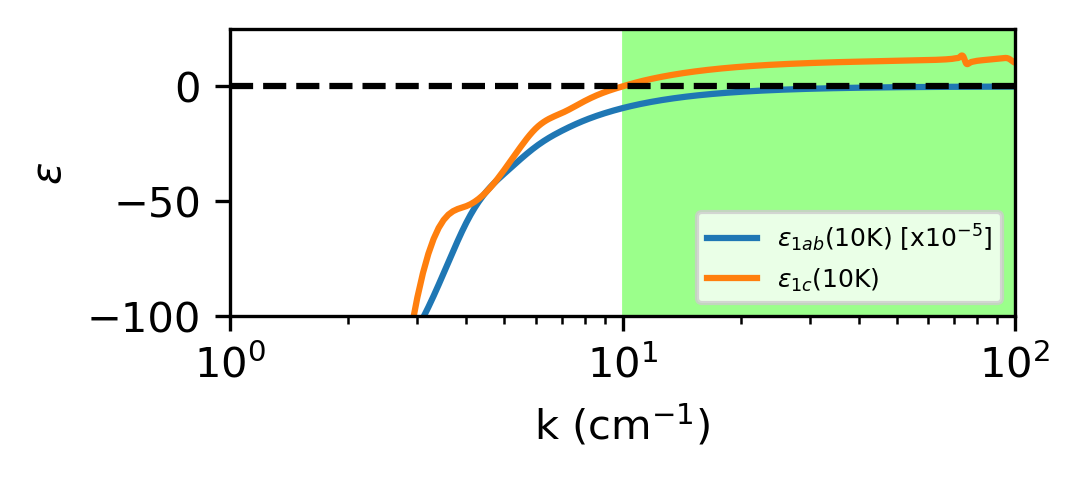

In [4]:
plot_opt_consts(BSCCO_data,
                opt_consts=['e1ab','e1c'], scale_factors = [10**(-5),1], temps=['10K'],
                axis=[1,100,-100,25],
                logx=True, logy=False,
                save=True, fname = "Figure1b.png",
                show_hyperbolic=True)

## Figure 2

### Setting up layer infrastructure

In [5]:
hBN_d   = 17e-7;
BSCCO_d = 50e-7;
mu      = 3000;

w_regime = {
    "IR": np.arange(300,1201,1),
    "THz_zoom": np.arange(3,30,0.01),
    "THz": np.arange(1,301,0.1),
    "Full": np.arange(1,1201,1)
};
q_regime = {
    "IR": np.arange(1,1e6,1e3),
    "THz_zoom": np.arange(1,1e4,1e1),
    "THz": np.arange(1,0.5e5,1e2),
    "Full": np.arange(1e3,1e6,1e3)
};

BSCCO = {
    '10K':  TabulatedAnisotropicMaterialFromFile('Bi2212_k_Tu_e1ab_e2ab_Tajima_e1c_e2c_10K_JPR_fixed.csv'),
    '150K': TabulatedAnisotropicMaterialFromFile('Bi2212_k_Tu_e1ab_e2ab_Kovaleva_e1c_e2c_150K.csv'),
    '300K': TabulatedAnisotropicMaterialFromFile('Bi2212_k_Tu_e1ab_e2ab_Tajima_e1c_e2c_300K.csv')
};
hBN = (BN_Caldwell,hBN_d);
BSCCO_HT = (BSCCO["150K"], BSCCO_d);
BSCCO_LT = (BSCCO["10K"], BSCCO_d);
graphene = SingleLayerGraphene(chemical_potential=mu);
surface = Surface();

layers_LT = LayeredMediaTM(
    hBN,
    surface,
    hBN,
    BSCCO_LT,
    exit=SiO2_300nm)
layers_HT = LayeredMediaTM(
    hBN,
    surface,
    hBN,
    BSCCO_HT,
    exit=SiO2_300nm)
layers_LT_MLG = LayeredMediaTM(
    hBN,
    graphene,
    hBN,
    BSCCO_LT,
    exit=SiO2_300nm)
layers_HT_MLG = LayeredMediaTM(
    hBN,
    graphene,
    hBN,
    BSCCO_HT,
    exit=SiO2_300nm)

### Calculating and plotting $r_p$ over THz regime

In [6]:
regime  = "THz";
ws = w_regime[regime];
qs = q_regime[regime];

rp_LT = np.transpose(np.imag(layers_LT.reflection_p(ws,qs)))
rp_HT = np.transpose(np.imag(layers_HT.reflection_p(ws,qs)))
rp_LT_MLG = np.transpose(np.imag(layers_LT_MLG.reflection_p(ws,qs)))
rp_HT_MLG = np.transpose(np.imag(layers_HT_MLG.reflection_p(ws,qs)))

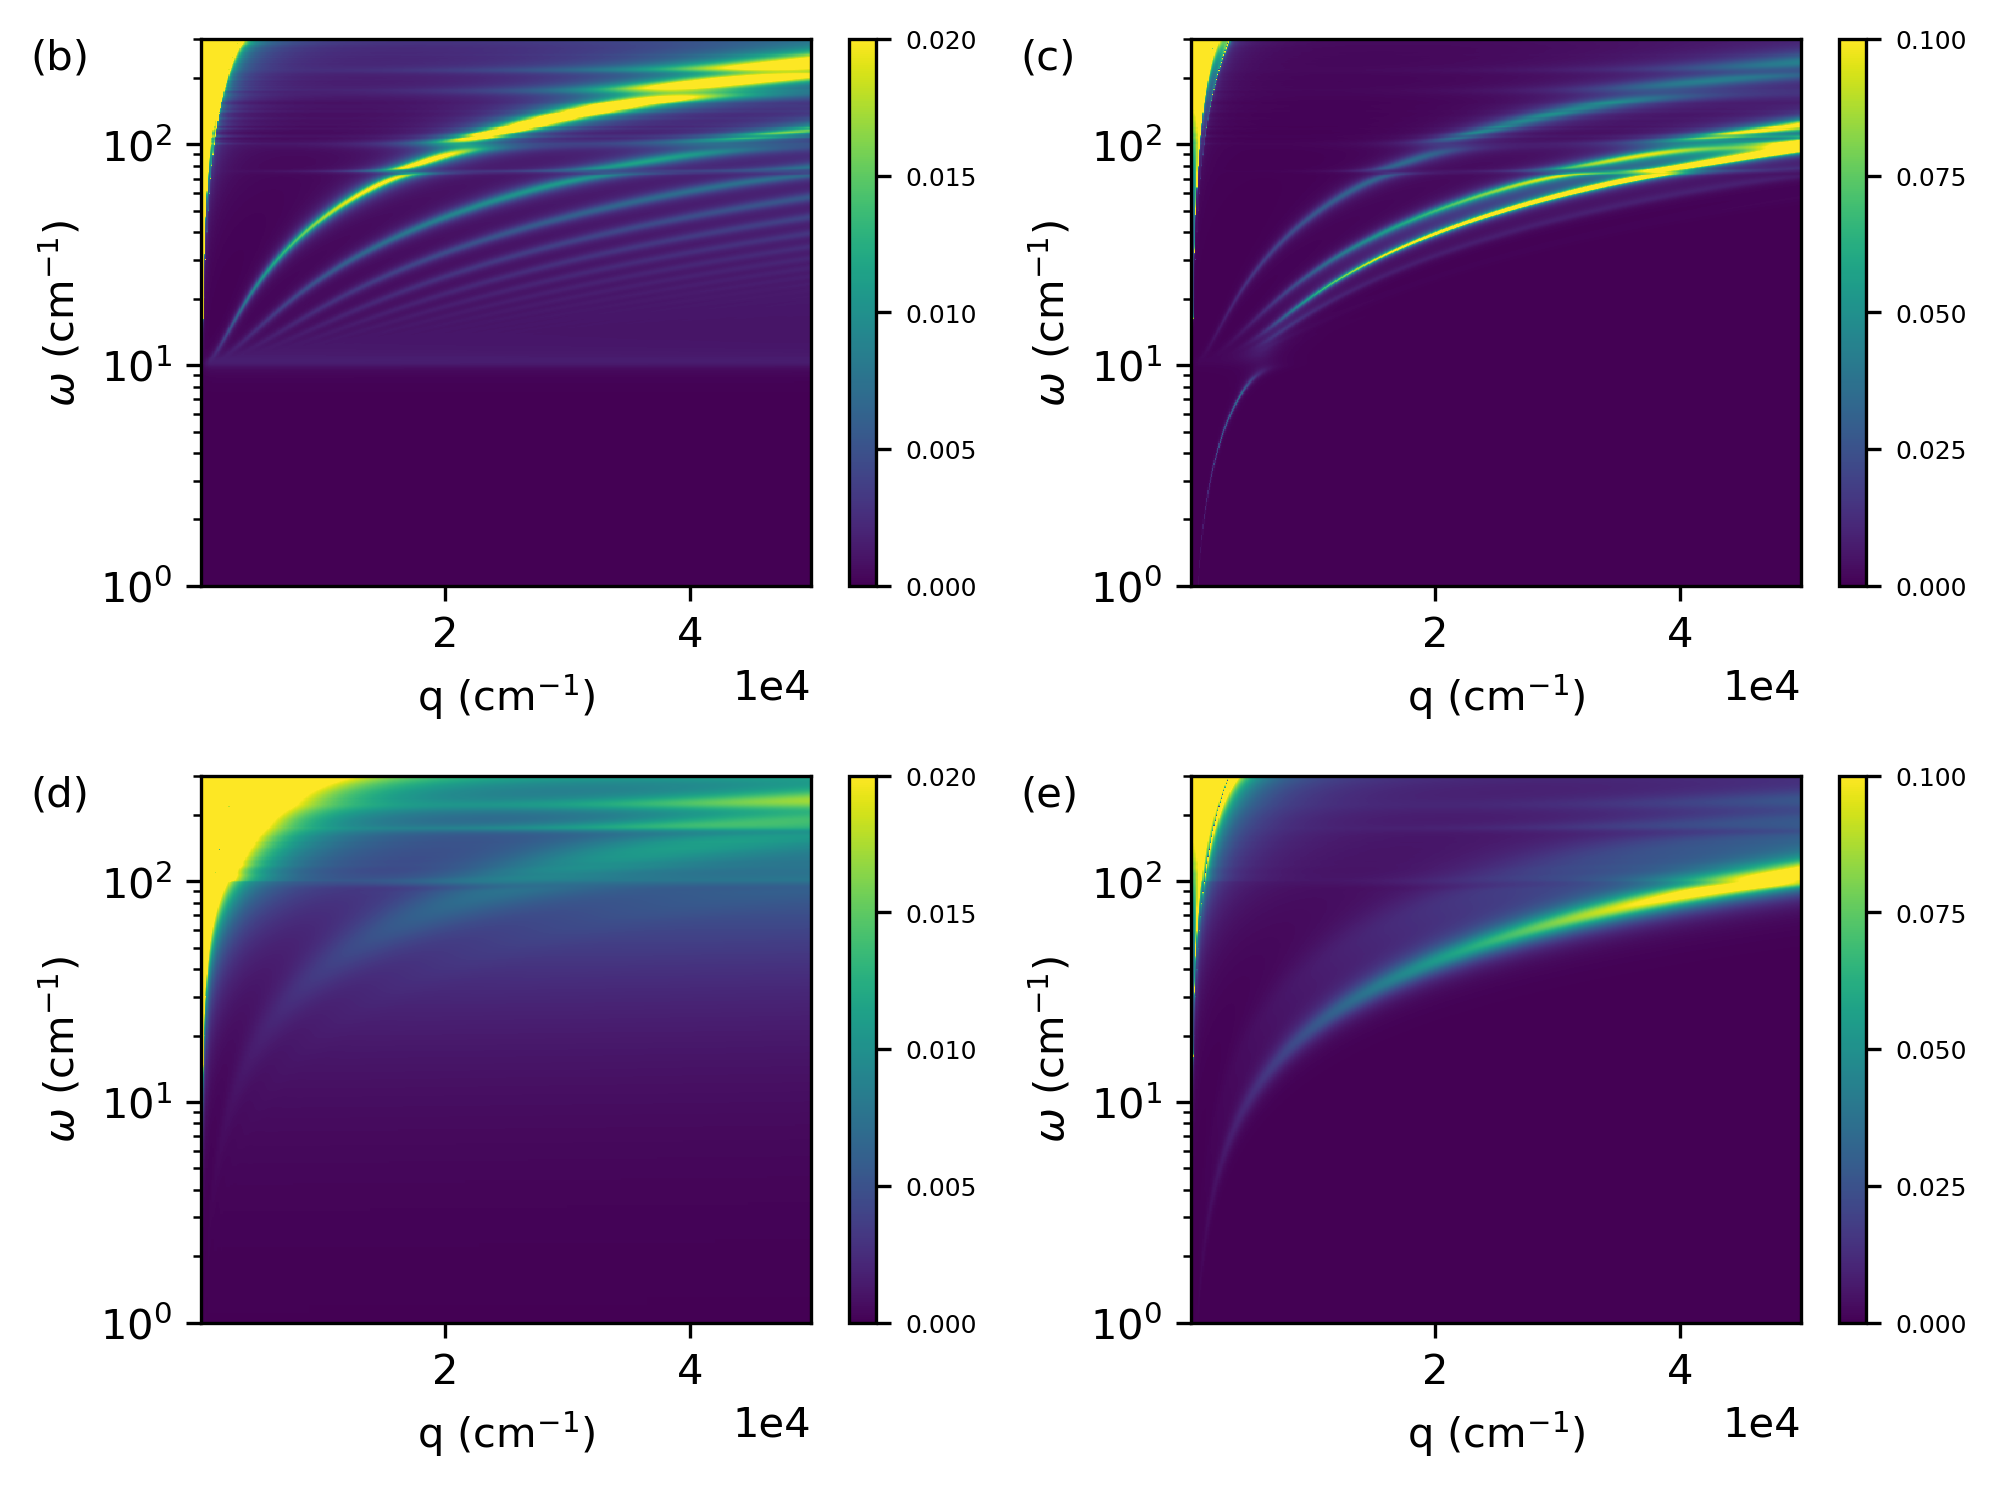

In [7]:
axis = [qs.min(), qs.max(), ws.min(), ws.max()]

fig,axes = plt.subplots(nrows=2, ncols=2,
            figsize=TWO_COL_FIGSIZE, dpi=DPI)
plots = [rp_LT, rp_LT_MLG, rp_HT, rp_HT_MLG]
#vmaxes = [0.3,0.3,0.3,0.3]
vmaxes = [0.02,0.1,0.02,0.1]
fig_labels = ["(b)", "(c)", "(d)", "(e)"]
n_ticks_cb = 5

for i in range(2):
    for j in range(2):
        plot_idx = 2*i+j;
        plot_vmax = vmaxes[plot_idx];
        plot_label = fig_labels[plot_idx];
        img = axes[i,j].imshow(plots[plot_idx],
                 origin="lower", aspect="auto",
                 vmin=0,vmax=plot_vmax, extent=axis)
        cb = plt.colorbar(img, ax=axes[i,j])
        cb.ax.tick_params(labelsize=6)
        cb.ax.yaxis.set_major_locator(plt.MaxNLocator(n_ticks_cb-1))
        cb.ax.set_yticklabels(["{:0.3f}".format(x) for x in np.linspace(0,vmaxes[plot_idx],n_ticks_cb,endpoint=True)])
        axes[i,j].text(-14000,220,plot_label);
        axes[i,j].set_xlabel("q (cm$^{-1}$)");
        axes[i,j].set_ylabel("$\omega$ (cm$^{-1}$)");
        axes[i,j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        #axes[i,j].set_xscale("log")
        axes[i,j].set_yscale("log")

plt.tight_layout()
plt.savefig("Figure2b-e.png", dpi=DPI, bbox_inches="tight")


## Figure 3

### Figure 3a

In [8]:
regime  = "THz_zoom";
ws = w_regime[regime];
qs = q_regime[regime];

rp_LT_MLG = np.transpose(np.imag(layers_LT_MLG.reflection_p(ws,qs)))

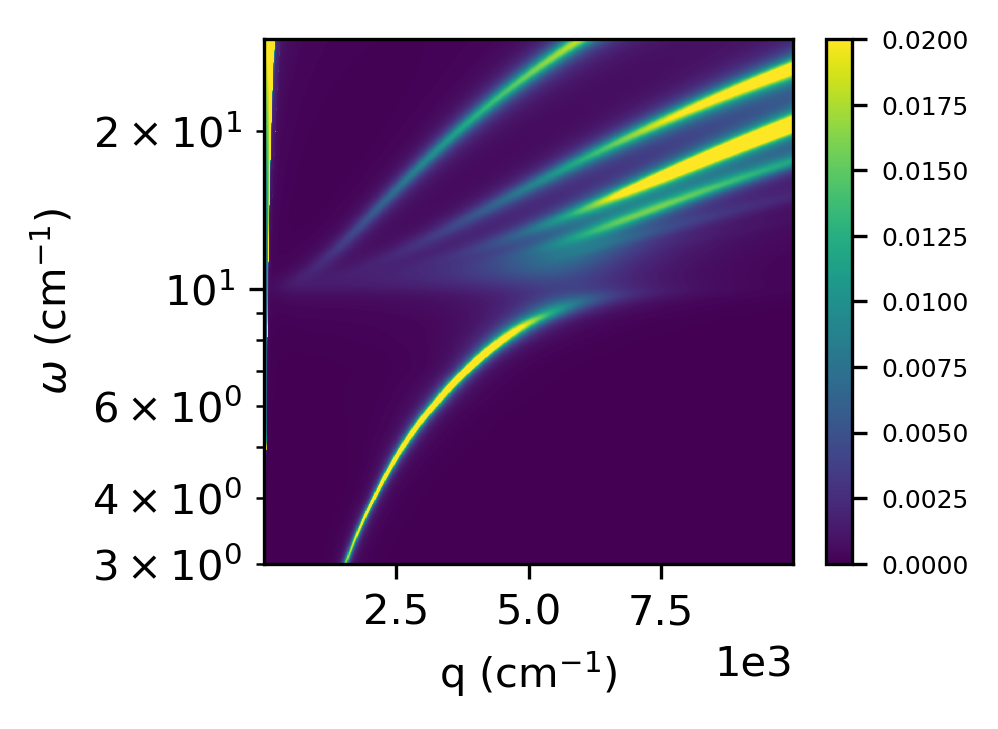

In [9]:
fig = plt.figure(figsize=ONE_COL_FIGSIZE, dpi=DPI);

axis = [qs.min(), qs.max(), ws.min(), ws.max()]

img = plt.imshow(rp_LT_MLG,
         origin="lower", aspect="auto",
         vmin=0,vmax=0.02, extent=axis)
axes = plt.gca()

cb = plt.colorbar(img, ax = axes)
cb.ax.tick_params(labelsize=6)
axes.set_xlabel("q (cm$^{-1}$)");
axes.set_ylabel("$\omega$ (cm$^{-1}$)");

axes.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes.set_yscale("log");
#axes.set_xticklabels([]);
#axes.set_yticklabels([]);
#plt.minorticks_off()
#axes.text(-3500,30,'(a)');

plt.tight_layout()
plt.savefig("Figure3a.png", dpi=DPI, bbox_inches="tight")

## Figure 4

### Figure 4b

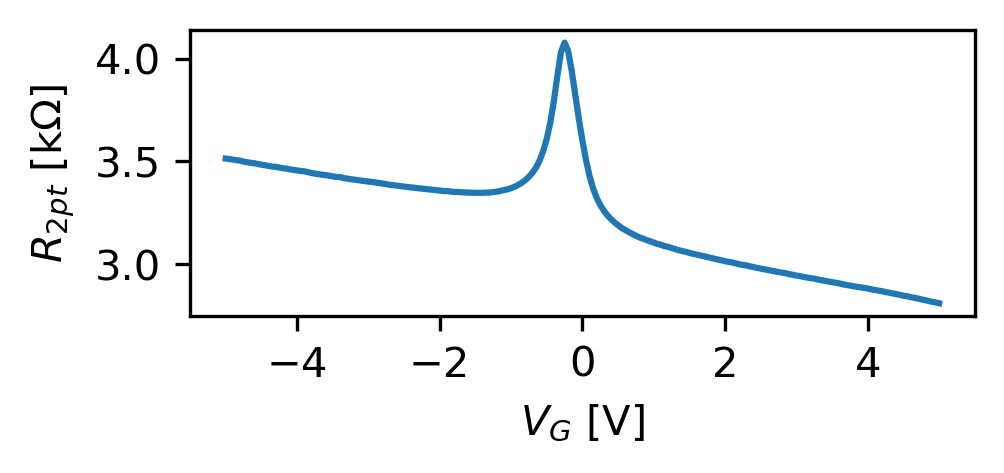

In [10]:
plt.figure(figsize=(3.375,3.375*0.5/ASPECT_RATIO), dpi=DPI);
plt.plot(BSCCO_data["300K"]["V"],BSCCO_data["300K"]["R"]);
plt.xlabel("$V_G$ [V]");
plt.ylabel("$R_{2pt}$ [k$\Omega$]");
plt.savefig("Figure4b.png", dpi=DPI, bbox_inches="tight");

# Extra plots

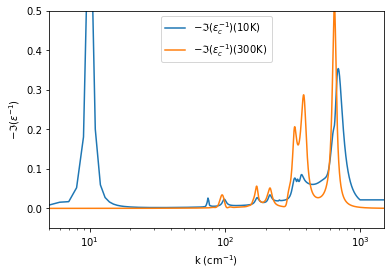

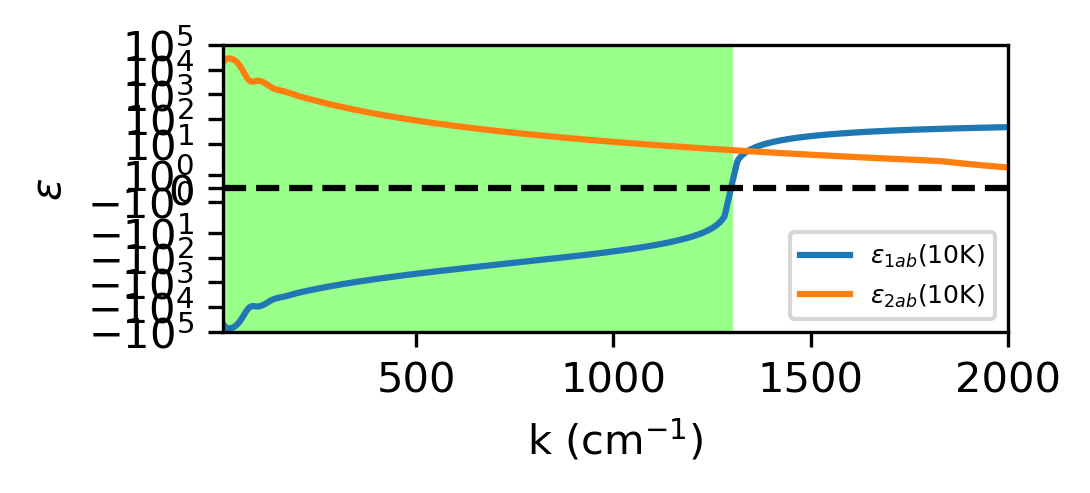

In [11]:
plot_loss(BSCCO_data,
          directions=['c'], temps=['10K', '300K'],
          axis=[5,1500,-0.05,0.5],
          logx=True, logy=False,
          save = False)

plot_opt_consts(DyBCO_data,
                opt_consts=['e1ab','e2ab'], temps=['10K'],
                axis=[10,2000,-1e5,1e5],
                logx=False, logy=True,
                save=False, show_hyperbolic=True)

In [12]:
def save_data(data, source='', material='BSCCO', opt_consts = ['e1ab'], temps = None):
    if temps is None:
        temps = list(data.keys())
    labels = ['k'] + opt_consts
    for temp in temps:
        fname = '_'.join([source, material, '_'.join(labels), temp])
        with open(fname, 'w') as csvf:
            writer = csv.writer(csvf, delimiter=',')
            nrows = len(data[temp]['k_'+opt_consts[0]])
            writer.writerow(labels)
            for i in range(nrows):
                row = []
                row.append(data[temp]['k_'+opt_consts[0]][i])
                for oc in opt_consts:
                    row.append(data[temp][oc][i])
                writer.writerow(row)

"""
save_data(data,
          source = "Zelenzy_2002",
          material = "BSCCO2212",
          opt_consts = ['e1ab', 'e2ab'])
"""

'\nsave_data(data,\n          source = "Zelenzy_2002",\n          material = "BSCCO2212",\n          opt_consts = [\'e1ab\', \'e2ab\'])\n'